In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pydicom import dcmread
import os, glob

# Read DICOM annotations

In [2]:
ANNOTATION_DIR = "/home/ERASMUSMC/099035/Documents/AnnotationFiles"

In [3]:
import glob

def list_annotations(annotation_dir,filename_expression = '*.dcm'):
    filenames = glob.glob(os.path.join(annotation_dir,filename_expression))
    filenames = sorted(filenames)
    print(f'There are {len(filenames)} annotations in the directory "{annotation_dir}"')
    return filenames

In [4]:
filenames = list_annotations(ANNOTATION_DIR)
filenames_size = len(filenames)

There are 1 annotations in the directory "/home/ERASMUSMC/099035/Documents/AnnotationFiles"


In [5]:
annotations_meta = dcmread(filenames[0])
annotations_meta['ApplicationSetupSequence'].value
#OR using the tag value
#annotations_meta[0x300A,0x0230].value

<Sequence, length 1>

In [11]:
annotations_meta.ApplicationSetupSequence[0].dir()

['ApplicationSetupNumber',
 'ApplicationSetupType',
 'ChannelSequence',
 'TotalReferenceAirKerma']

In [6]:
channel_seq = annotations_meta.ApplicationSetupSequence[0].ChannelSequence

In [7]:
channel_seq

<Sequence, length 19>

In [8]:
sequence = annotations_meta[0x300A,0x0230].value

In [9]:
sequence[0].ChannelSequence

<Sequence, length 19>

In [10]:
annotations_meta.ApplicationSetupSequence[0].ChannelSequence[0].BrachyControlPointSequence[41].ControlPoint3DPosition

[2.323375, -188.210950, -907.822920]

In [11]:
# Create a class for the Dwell Data
class DwellData:
    channel = np.array([np.nan])
    position = np.array([np.nan])
    coordinates = np.array([0])

    def __init__(self,filename):
        annotations_metadata = dcmread(filename)
        # ApplicationSetupSequence is of Class type 'Sequence' from pydicom docs
        channel_seq = annotations_metadata.ApplicationSetupSequence[0].ChannelSequence
        k=0
        for c in range(0,len(channel_seq)):
            control_point_seq = channel_seq[c].BrachyControlPointSequence
            relative_position = float('NaN')
            # Initialize arrays if its the first pass
            # Checks if any of the values evaluates to True (non zero)
            is_nan = np.isnan(self.channel)
            if (np.all(is_nan) == True):
                print('In  here')
                # Initialize numpy arrays with zeros (1D,1D,3D)
                self.channel = np.full((len(channel_seq) * len(control_point_seq)), np.nan)
                self.position = np.full((len(channel_seq) * len(control_point_seq)), np.nan)
                self.coordinates = np.zeros([len(channel_seq) * len(control_point_seq),3])
            # Loop in the BrachyControlPointSequence from index len(seq)-1 to 0
            for i in range(len(control_point_seq)-1,-1,-1):
                if (control_point_seq[i].ControlPointRelativePosition!=relative_position):
                    relative_position = control_point_seq[i].ControlPointRelativePosition
                    self.channel[k] = c + 1
                    self.position[k] = relative_position
                    self.coordinates[k,:] = control_point_seq[i].ControlPoint3DPosition
                    k+=1
        self.channel = self.channel[np.isnan(self.channel) == False].astype('int32')
        self.position = self.position[np.isnan(self.position) == False].astype('int32')
        self.coordinates = self.coordinates[self.coordinates != 0].reshape((-1,3))
            

In [12]:
PointData = DwellData(filenames[0])
PointData

In  here


In [13]:
PointData.coordinates[0]

array([   2.323375, -188.21095 , -907.82292 ])

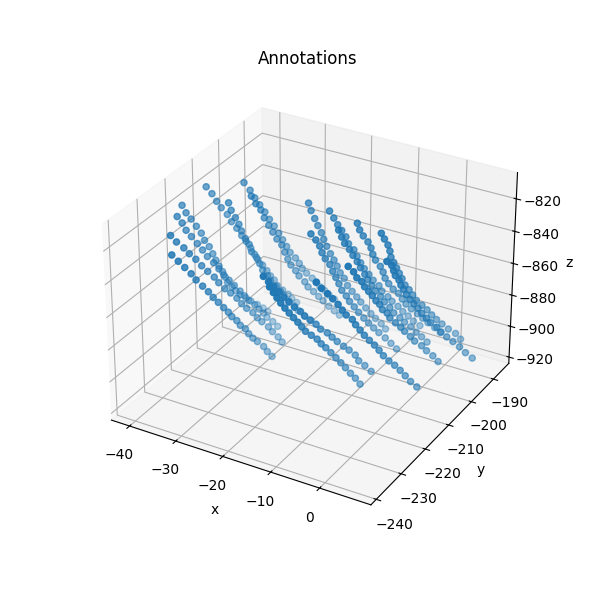

In [14]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(PointData.coordinates[:,0],PointData.coordinates[:,1],PointData.coordinates[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Annotations")
plt.show()

# Curve Fitting

In [15]:
from scipy.optimize import curve_fit

In [16]:
# Define mathematical function
# Polynomial function of degree 3
# Will use this function for every channel i.e every catheters points
def func(xy,a,b,c,d):
    x, y = xy
    #return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y
    return a + b*x + c*y + d*x*y

In [17]:
# Calculate curve fit parameters
def calculate_curve_fit(func,x,y,z):
    popt, pcov = curve_fit(func,(x,y),z,p0=[1 , 0.5 , 0.5,0.5])#method = 'trf'
    return popt,pcov

In [18]:
# Correlate coordinates with channel
# V2 is faster
def match_coordinate_channel_V2(point_data):
    channel_length = len(np.unique(point_data.channel))
    number_of_coordinates_per_channel = int(point_data.coordinates.shape[0]/channel_length)
    channel_coordinates = np.reshape(point_data.coordinates,(channel_length,number_of_coordinates_per_channel,3))
    return channel_coordinates

def match_coordinate_channel_V1(point_data):
    channel_length = len(np.unique(point_data.channel))
    channel_coordinates = np.zeros((channel_length,int(point_data.coordinates.shape[0]/channel_length),3))
    #print(channel_coordinates.shape)
    for i in range(0,channel_length):
        temp_channel = np.where(point_data.channel == i+1,True,False)
        #print(temp_channel)
        channel_coordinates[i,:,:] = point_data.coordinates[temp_channel]
    return channel_coordinates

In [19]:
%timeit channel_coordinates = match_coordinate_channel_V2(PointData)

24.2 µs ± 125 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
%timeit channel_coordinates = match_coordinate_channel_V1(PointData)

415 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
# Find max and min values of a channel
def find_min_max_single(single_channel_coordinates):
    X_max = np.max(single_channel_coordinates[:,0])
    X_min = np.min(single_channel_coordinates[:,0])
    Y_max = np.max(single_channel_coordinates[:,1])
    Y_min = np.min(single_channel_coordinates[:,1])
    return X_max,X_min,Y_max,Y_min

In [22]:
# Find max and min values of all channels
def find_min_max_all(all_channel_coordinates):
    channel_length = all_channel_coordinates.shape[0]
    X_max = np.zeros((channel_length))
    X_min = np.zeros((channel_length))
    Y_max = np.zeros((channel_length))
    Y_min = np.zeros((channel_length))
    for i in range(0,channel_length):
        X_max[i],X_min[i],Y_max[i],Y_min[i] = find_min_max_single(all_channel_coordinates[i,:,:])
    return X_max,X_min,Y_max,Y_min

In [48]:
# Match coordinates to their channels
channel_coordinates = match_coordinate_channel_V2(PointData)
# Find max and min values from X and Y coordinates
channel_coordinates_max_min = np.array(find_min_max_all(channel_coordinates))
channel_coordinates_max_min = channel_coordinates_max_min.T
# channel_coordinates_max_min columns are X_max,X_min,Y_max,Y_min
Z_fitted = np.zeros((channel_coordinates.shape[0],100))
x_ranges = np.zeros((channel_coordinates.shape[0],100))
y_ranges = np.zeros((channel_coordinates.shape[0],100))
popt = np.zeros((channel_coordinates.shape[0],4))
pcov = np.zeros((channel_coordinates.shape[0],4,4))
for i in range(0,channel_coordinates.shape[0]):
    # Perform Curve fitting
    x = channel_coordinates[i,:,0] #/ np.max(channel_coordinates[i,:,0])
    y = channel_coordinates[i,:,1] #/ np.max(channel_coordinates[i,:,1])
    z = channel_coordinates[i,:,2] #/ np.max(channel_coordinates[i,:,2])
    popt[i,:], pcov[i,:,:] = calculate_curve_fit(func,x,y,z)
    # Define range of curve fit line
    x_range = np.linspace(channel_coordinates_max_min[i,1],channel_coordinates_max_min[i,0],100)
    y_range = np.linspace(channel_coordinates_max_min[i,3],channel_coordinates_max_min[i,2],100)
    x_ranges[i,:] = x_range
    y_ranges[i,:] = y_range
    #x_range, y_range = np.meshgrid(x_range, y_range)
    # Calculate Z from X and Y coordinates
    Z_fitted[i,:] = func((x_range,y_range), *popt[i,:])
    #Z_fitted[i,:] = func((X,Y), *popt)
Z_fitted.shape

(19, 100)

In [24]:
popt[0,:]

array([-1.77196548e+03, -6.91010852e+00, -4.54687352e+00, -5.84521488e-02])

In [25]:
np.linalg.cond(pcov[:,:])

array([4.97275613e+09, 5.86522196e+11, 1.56574782e+12, 1.81652820e+14,
       4.65565260e+09, 1.10610322e+12, 1.31819020e+12, 1.63833503e+13,
       2.91231024e+14, 4.76709375e+09, 7.51809547e+12, 3.57577983e+13,
       3.37339417e+14, 1.83046046e+14, 4.98908092e+10, 1.67428488e+12,
       3.61141659e+13, 2.47484043e+13, 6.83867499e+13])

In [26]:
np.diag(pcov[0,:,:])

array([6.96817751e+02, 5.50710813e+01, 1.87076212e-02, 1.59993938e-03])

In [27]:
PointData.coordinates[2,:]

array([   1.009936, -191.105789, -898.403427])

In [28]:
channel_coordinates[0,2,:]

array([   1.009936, -191.105789, -898.403427])

In [29]:
PointData.coordinates.shape

(399, 3)

In [30]:
channel_coordinates.shape

(19, 21, 3)

In [31]:
PointData.coordinates[0,:]

array([   2.323375, -188.21095 , -907.82292 ])

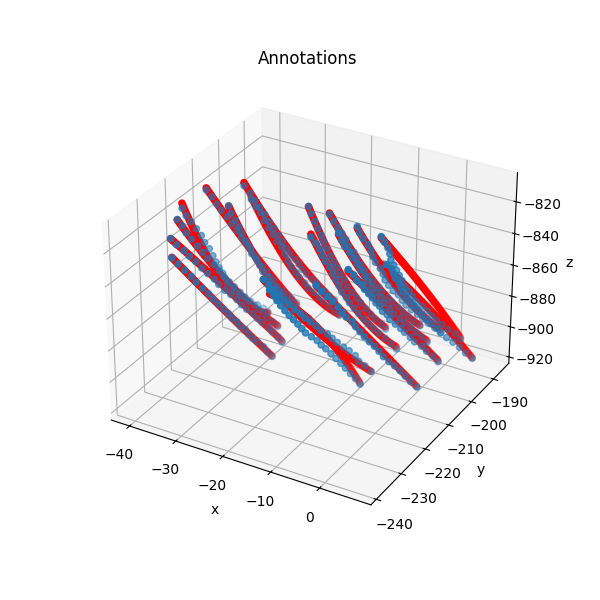

In [32]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(PointData.coordinates[:,0],PointData.coordinates[:,1],PointData.coordinates[:,2])
# For all channels (catheters)
for i in range(0,Z_fitted.shape[0]):
    ax.scatter3D(x_ranges[i,:],y_ranges[i,:],Z_fitted[i,:], color="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Annotations")
#ax.view_init(90)
plt.show()


In [33]:
Z_fitted[0,97]

-904.6451210994474

In [36]:
channel_coordinates[0,:,0].shape

(21,)

In [147]:
# Try new methods : RBFinterpolator
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import SmoothBivariateSpline
# Match coordinates to their channels
channel_coordinates = match_coordinate_channel_V2(PointData)
# Find max and min values from X and Y coordinates
channel_coordinates_max_min = np.array(find_min_max_all(channel_coordinates))
channel_coordinates_max_min = channel_coordinates_max_min.T
# channel_coordinates_max_min columns are X_max,X_min,Y_max,Y_min
Z_fitted = np.zeros((channel_coordinates.shape[0],100))
for i in range(0,channel_coordinates.shape[0]):
    # Perform Curve fitting
    x = channel_coordinates[i,:,0] #/ np.max(channel_coordinates[i,:,0])
    y = channel_coordinates[i,:,1] #/ np.max(channel_coordinates[i,:,1])
    #xy = np.vstack((x,y))
    #print(xy.shape)
    #print(xy[0,0],xy[1,0])
    #xy = xy.T
    #print(xy.shape)
    #print(xy[0,0],xy[0,1])
    z = channel_coordinates[i,:,2] #/ np.max(channel_coordinates[i,:,2])
    weights = np.zeros((channel_coordinates[i,:,0].shape))
    #spline = RBFInterpolator(xy,z,kernel = 'cubic')
    spline = SmoothBivariateSpline(x,y,z, s=0.0)
    x_range = np.linspace(channel_coordinates_max_min[i,1],channel_coordinates_max_min[i,0],100) #/ np.max(channel_coordinates[i,:,0])
    y_range = np.linspace(channel_coordinates_max_min[i,3],channel_coordinates_max_min[i,2],100) #/ np.max(channel_coordinates[i,:,1])
    x_ranges[i,:] = x_range
    y_ranges[i,:] = y_range
    Z_fitted[i,:] = spline.ev(x_range,y_range)    

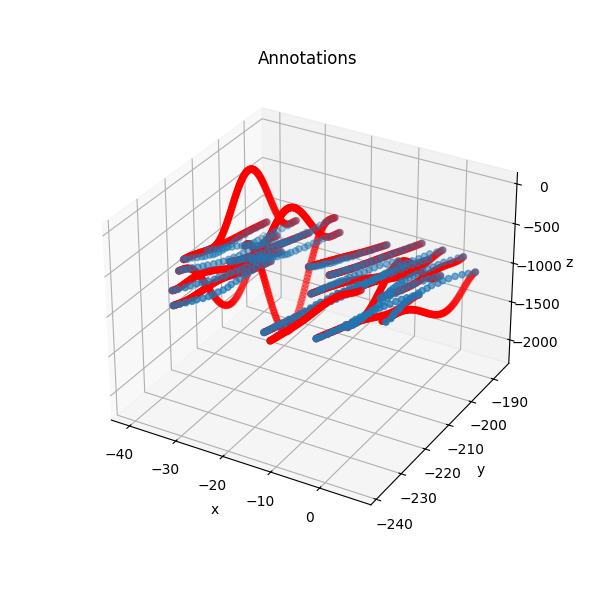

In [150]:
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(PointData.coordinates[:,0],PointData.coordinates[:,1],PointData.coordinates[:,2])
# For all channels (catheters)
for i in range(0,Z_fitted.shape[0]):
    ax.scatter3D(x_ranges[i,:],y_ranges[i,:],Z_fitted[i,:], color="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Annotations")
#ax.view_init(90)
plt.show()

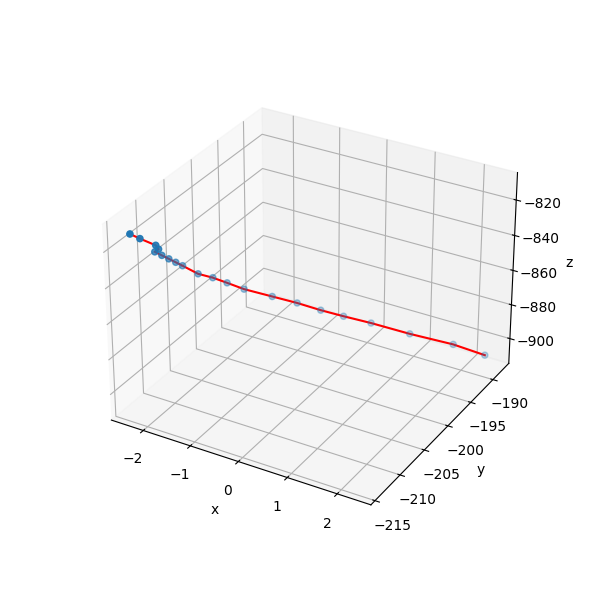

In [177]:
from scipy.interpolate import splprep, splev
x = channel_coordinates[0,:,0] #/ np.max(channel_coordinates[i,:,0])
y = channel_coordinates[0,:,1] #/ np.max(channel_coordinates[i,:,1])
z = channel_coordinates[0,:,2] #/ np.max(channel_coordinates[i,:,2])
tck, u = splprep([x,y,z],s=0)
#spl = splprep([x,y,z],s=0)
#new_points = splev(u, tck)
#print(new_points[0])

x_range = np.linspace(channel_coordinates_max_min[0,1],channel_coordinates_max_min[0,0],100) #/ np.max(channel_coordinates[i,:,0])
y_range = np.linspace(channel_coordinates_max_min[0,3],channel_coordinates_max_min[0,2],100) #/ np.max(channel_coordinates[i,:,1])
new_points = splev(u, tck)

fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(PointData.coordinates[0:21,0],PointData.coordinates[0:21,1],PointData.coordinates[0:21,2],'b')
ax.plot(new_points[0], new_points[1],new_points[2], 'r-')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

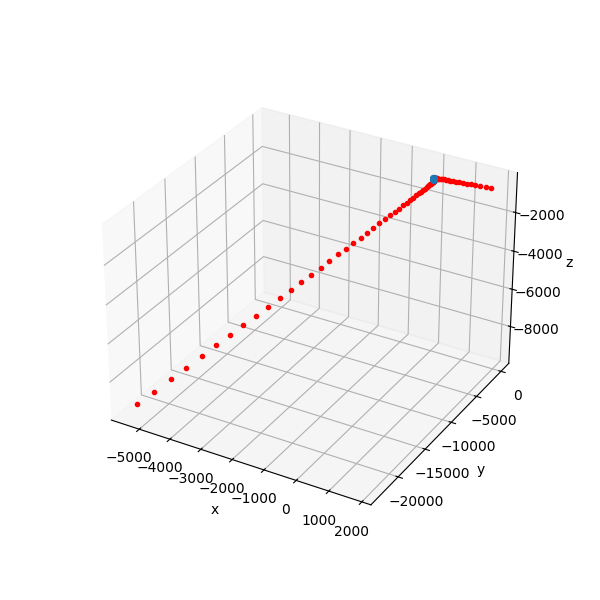

In [181]:
from scipy.interpolate import BSpline
t, c, k = tck
c1 = np.asarray(c)
spl = BSpline(t, c1.T, k)
z_new = spl(x_range)
z_new.shape
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(PointData.coordinates[0:21,0],PointData.coordinates[0:21,1],PointData.coordinates[0:21,2],'b')
ax.plot(z_new[:,0],z_new[:,1],z_new[:,2], 'r.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

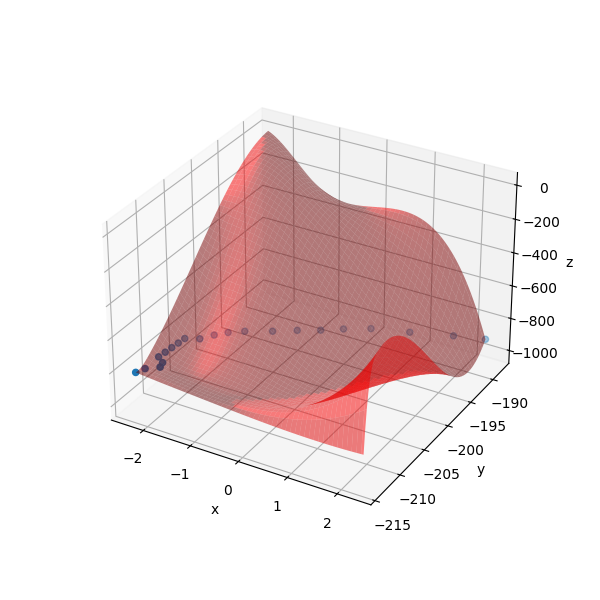

In [184]:
from scipy.interpolate import bisplrep, bisplev
x = channel_coordinates[0,:,0] #/ np.max(channel_coordinates[i,:,0])
y = channel_coordinates[0,:,1] #/ np.max(channel_coordinates[i,:,1])
z = channel_coordinates[0,:,2] #/ np.max(channel_coordinates[i,:,2])
tck = bisplrep(x,y,z,s=0)

#print(new_points[0])

x_range = np.linspace(channel_coordinates_max_min[0,1],channel_coordinates_max_min[0,0],100) #/ np.max(channel_coordinates[i,:,0])
y_range = np.linspace(channel_coordinates_max_min[0,3],channel_coordinates_max_min[0,2],100) #/ np.max(channel_coordinates[i,:,1])

znew = bisplev(x_range,y_range, tck)

fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(PointData.coordinates[0:21,0],PointData.coordinates[0:21,1],PointData.coordinates[0:21,2],'b')
X,Y = np.meshgrid(x_range,y_range)
ax.plot_surface(X,Y,znew,color='red',alpha=0.5)
#ax.plot(x_range[50], y_range[50], znew[0,50], 'r.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()